In [1]:
%matplotlib inline
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import imageio
from numpy.random import randint, shuffle, choice

# Simulation based statistics with real life applications

Sources:

* [Talk by Jake VanderPlas](https://www.youtube.com/watch?v=Iq9DzN6mvYA)
* [Slides by Jake VanderPlas](https://speakerdeck.com/jakevdp/statistics-for-hackers)
* [RANDOM PERMUTATION TESTS](http://danielnee.com/2015/01/random-permutation-tests/)
* [Statistics Without the Agonizing Pain](https://www.youtube.com/watch?v=5Dnw46eC-0o)
* Book "Statistics is Easy" 2nd ed, Dennis Shasha and Manda Wilson

Main methods covered in this notebook:

1. **Direct simulations**
2. **Shuffling**
3. **Bootstrapping**
4. **Cross Validation**

Real-life applications:

1. Statistical tests
2. A/B Testing
3. ML model evaluation
4. ... 

# Hypothesis testing: Coin toss

We will start with the simplest task possible - coin toss.

**TASK:** Coin tossed 17 times produced 2 tails. Is it fair?

## Classic Method

$$
P\left(N_{H},N_{T}\right)=\left(\begin{array}{c}
N_{H}+N_{T}\\
N_{H}
\end{array}\right)\left(\frac{1}{2}\right)^{N_{H}}\left(1-\frac{1}{2}\right)^{N_{T}}
$$

## Using direct simulation

We can solve this easily using direct simulation as follows.

In [7]:
n_exp = 10000000
data = np.sum(np.random.randint(0, 2, size=[17, n_exp]), axis=0)

/home/trokas/anaconda3/envs/ai_primer/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


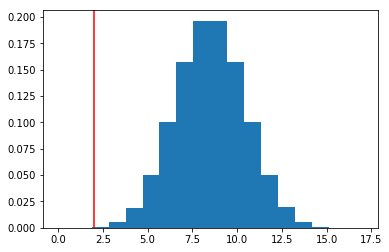

In [8]:
plt.hist(data, bins=18, normed = True)
plt.axvline(x = 2, color = 'red')
plt.show()

In [9]:
print('Probability according to simulation: {:.4%}'.format(np.mean(data == 2)))

Probability according to simulation: 0.1053%


Acctual probability is 0.103759765625%. Note that making more simulations yeld more reliable results than making multiple small simulations.

**Tip:** use numpy matrix to make calculations faster. For more complex simulations *numba* might be handy.

# Shuffling: Placebo vs Drug

Lets say, that after performing experiment we obtained following measurements:

* Placebo: 54 51 58 44 55 52 42 47 58 46
* Drug: 54 73 53 70 73 68 52 65 65

**Problem:** is this drug useful?

What is probability that assigning labels on random will lead to such mean difference.

In [11]:
placebo = np.array([54,51,58,44,55,52,42,47,58,46])
drug = np.array([54,73,53,70,73,68,52,65,65])
data = np.append(placebo, drug)
p_len = placebo.shape[0]
expected = drug.mean() - placebo.mean()
print("Impact on means: {0}".format(expected))

Impact on means: 12.966666666666661


In [12]:
means = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    means = np.append(means, permuted[p_len:].mean() - permuted[:p_len].mean())

/home/trokas/anaconda3/envs/ai_primer/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


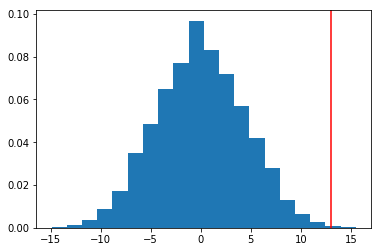

In [13]:
plt.hist(means, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()

In [14]:
print('Probability that this is due to random event: {:.4%}'.format(np.mean(means >= expected)))

Probability that this is due to random event: 0.0780%


This means that there is only 0.1% chance that such difference have been observed randomly.
Another example:
* Placebo 56 348 162 420 440 250 389 476 288 456 
* Drug +13

Impact on means: 13.0


/home/trokas/anaconda3/envs/ai_primer/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


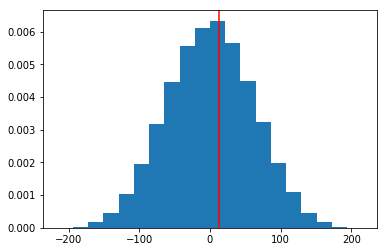

Probability that this is due to random event: 42.1670%


In [15]:
placebo = np.array([56,348,162,420,440,250,389,476,288,456])
drug = placebo + 13
data = np.append(placebo, drug)
p_len = placebo.shape[0]
expected = drug.mean() - placebo.mean()
print("Impact on means: {0}".format(expected))
means = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    means = np.append(means, permuted[p_len:].mean() - permuted[:p_len].mean())
plt.hist(means, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()
print('Probability that this is due to random event: {:.4%}'.format(np.mean(means >= expected)))

Note that **Significance** does not tell about **effect**!

# A/B Testing

Let's say that we have following obervations:

* In target group 20 customers churned from 500.
* In control group 70 customers churned from 1000.

Is this significant impact?

Shuffling might be usefull in this case.

Impact on churn rate: -0.030000000000000006


/home/trokas/anaconda3/envs/ai_primer/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


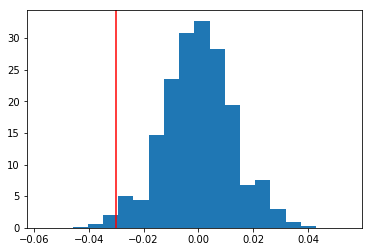

Probability that this is due to random event: 0.9080%


In [16]:
target = np.append(np.zeros(480), np.ones(20))
control = np.append(np.zeros(930), np.ones(70))
data = np.append(target, control)
split = target.shape[0]
expected = np.sum(target)/target.shape[0] - np.sum(control)/control.shape[0]
print("Impact on churn rate: {0}".format(expected))
rates = np.array([])
for _ in range(100000):
    permuted = np.random.permutation(data)
    rates = np.append(rates, np.sum(permuted[split:])/permuted[split:].shape[0] - np.sum(permuted[:split])/split)
plt.hist(rates, bins = 20, normed = True)
plt.axvline(x = expected, color = 'red')
plt.show()
print('Probability that this is due to random event: {:.4%}'.format(np.mean(rates < expected)))

# Boostrapping

“What is the 90% confidence interval of difference in the averages
between the drug patients and placebo?”

Bootstrapping - simulate distribution by drawing random samples with replacement.

In [26]:
df = pd.DataFrame()
df['score'] = [54,51,58,44,55,52,42,47,58,46,54,73,53,70,73,68,52,65,65]
df['label'] = ['D' if s<10 else 'P' for s in range(19)]

In [27]:
evaluation = pd.DataFrame()
evaluation['rand'] = np.array([choice(df[df.label == 'P']['score'].values, 10).mean() - 
        choice(df[df.label == 'D']['score'].values, 10).mean() for _ in range(10000)])

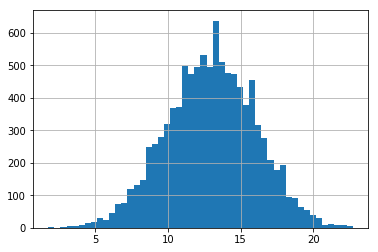

In [28]:
evaluation['rand'].hist(bins = 50)

In [29]:
evaluation['rand'].quantile([0.05, 0.95])

0.05     7.900
0.95    17.905
Name: rand, dtype: float64

This means that 90% of the time Drug will give average value higher than Placebo in range 7.9, 18.

Next example consists of incomes.

In [30]:
df = pd.DataFrame()
df['incomes'] = [200,69,141,45,154,169,142,198,178,197,1000000,166,188,178,129,87,151,101,187,154]

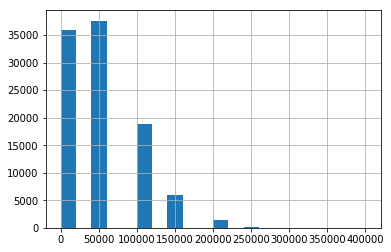

In [31]:
evaluation = pd.DataFrame()
evaluation['rand'] = np.array([choice(df['incomes'].values, df.shape[0]).mean() for _ in range(100000)])
evaluation['rand'].hist(bins = 20)

In [32]:
evaluation['rand'].quantile([0.05, 0.95])

0.05       138.45
0.95    150125.80
Name: rand, dtype: float64

Note that this is a huge range of values, thus we can say that average is uninformative in such case!

If you’ve been following this carefully, you might now wonder “If I have a confidence interval,
what more does significance bring to the party?” To answer this intuitively, consider a simple
example in which you have just one element of group A having value 50 and one element of group
B having value 40. The confidence interval using replacement will say that the difference is always 10. 
But intuitively this is way too little data. The significance test (in which one permutes the group
labels) will show that half the time one will get, just by random chance, a difference as big as the
observed one. 

## Cross validation

This is core idea which we will use for model evaluation nearly each time. 

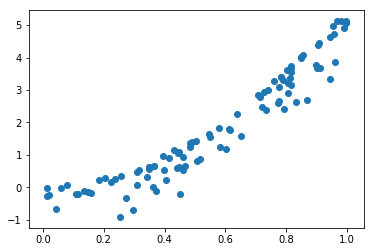

In [108]:
x = np.random.rand(100)
x.sort()
y = x / 2 + 5 * x**2 + np.log(np.random.rand(100))/3
plt.scatter(x,y)
plt.show()

Let's fit couple of models.

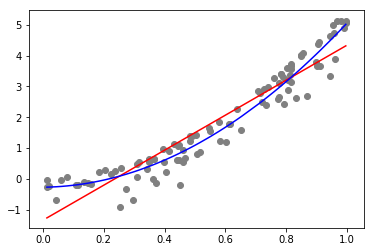

In [109]:
f_line = np.poly1d(np.polyfit(x, y, 1))
f_poly = np.poly1d(np.polyfit(x, y, 2))
y_line = f_line(x)
y_poly = f_poly(x)
plt.scatter(x, y, color = 'grey')
plt.plot(x, y_line, color = 'red')
plt.plot(x, y_poly, color = 'blue')
plt.show()

Now we will randomly split data and in each run evaluate RMSE.

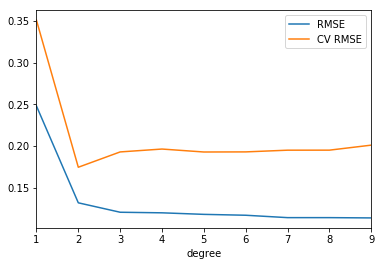

In [113]:
mask = np.random.rand(x.shape[0]) > 0.5

L = []
for degree in range(1, 10):
    E = []   # storage for errors
    CV = []   # storage for cross validated errors
    for _ in range(1000):    # let's make it more robust
        # fit using mask
        f = np.poly1d(np.polyfit(x[mask], y[mask], degree))
        # evaluate on masked dataset
        E.append(np.mean((f(x[mask]) - y[mask])**2))
        CV.append(np.mean((f(x[~mask]) - y[~mask])**2))
    L.append([degree, np.mean(E), np.mean(CV)])

df = pd.DataFrame(L, columns=['degree', 'RMSE', 'CV RMSE']).set_index('degree')
df.plot()

# Gradient descent

We have observed that simple simulations can solve complex problems. We will see now how we can apply this paradigm for optimization problems.

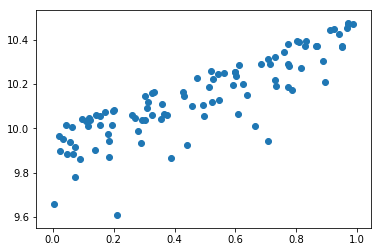

In [2]:
np.random.seed(42)
x = np.random.rand(100)
x.sort()
y = x / 2 + np.log(np.random.rand(100))/10 + 10
plt.scatter(x,y)
plt.show()

In [6]:
k, b = 0, 0     # initial values
epochs = 1000
learning_rate = 0.1

L = []   # storage for k and b through training
for i in range(epochs):
    pred = k * x + b
    L.append([k, b])
    pred_diff_k = x
    pred_diff_b = 1
    k += 2 * learning_rate * np.mean(pred_diff_k * (y - pred))
    b += 2 * learning_rate * np.mean(pred_diff_b * (y - pred))

print('Obtained parameters: k = {0:.04f}, b = {1:.04f}'.format(k, b))

Obtained parameters: k = 0.5271, b = 9.8882


In [7]:
print('Exact solution: k = {0:.04f}, b = {1:.04f}'.format(*np.polyfit(x, y, 1)))

Exact solution: k = 0.5271, b = 9.8882


In [8]:
images = []
for i in range(epochs)[::10]:
    f_line = np.poly1d(L[i])
    plt.scatter(x, y, color = 'grey')
    plt.title('k = {0:.04f}, b = {1:.04f}'.format(*L[i]))
    plt.plot(x, f_line(x), color = 'red')
    plt.ylim(9.25, 10.75)
    plt.savefig('img/grad_desc/{0}.jpg'.format(i))
    images.append(imageio.imread('img/grad_desc/{0}.jpg'.format(i)))
    plt.close()

imageio.mimsave('img/grad_desc_demo.gif', images, duration=0.1)

![Gradient descent demo](img/grad_desc_demo.gif)

This principle will be used throughout the course and is main ingredients of neural net models!